Test assignment for corementor.ai. Done by Daniil Fishman. 

Date: January 31, 2021

Since the goal was to demonstrate my ability to work with specific data in a fairly short period of time, I decided to choose the jupyter notebook as a demonstration of my capabilities. It is more convenient to write comments and explain my actions. However, for the working prototype it is of course better to use python scripts. 

In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

## Load Libs

In [2]:
import SimpleITK as sitk
import nibabel as nib
import numpy as np

import segmentation_models_pytorch as smp
from torch.optim import AdamW, Adam 
from torch import LongTensor, FloatTensor
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import Dataset, DataLoader
import torch
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from albumentations import (
    HorizontalFlip, ElasticTransform, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, 
    RandomRotate90, RandomContrast, Transpose, ShiftScaleRotate, Blur, OpticalDistortion, 
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, RandomBrightness, GaussNoise, 
    MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop, IAASharpen, IAAEmboss, 
    RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, 
    CenterCrop, Resize
)
from albumentations.pytorch import ToTensorV2

## Config

In [4]:
bs = 16
loss = BCEWithLogitsLoss()
metric = smp.utils.losses.DiceLoss()

In [5]:
train_tranforms = Compose([
                    HorizontalFlip(p=0.5),
                    VerticalFlip(p=0.5),
                    ])
val_transforms = Compose([
])

## Functions

Here we have some funcions what we wil need later:

*array2mask*: Transform the original 512x512 matrix with labels into a 512x512x20 matrix. This is necessary to train the model. 

*mask2array*: reverce array2mask 

*dice_score*: by given mask and prediction calculates dice score

*mask_tresholed*: treshold mask into matrix with only 0s and 1s

*plot_samples*: plot orginal brain images and images after affine tranformation

In [6]:
# transform array with labels (1,...,20) to mask for each label. output array with shape (512, 512, 20)
def array2mask(array, nlabels = 20):
    mask =  np.zeros((array.shape[0], array.shape[1], nlabels))
    for label in range(1,nlabels+1):
        mask[:,:, label-1 : label] = np.expand_dims(array, -1)==label
    return mask

In [7]:
# reverce array2mask
def mask2array(mask, nlabels = 20):
    array =  np.zeros((mask.shape[0], mask.shape[1], 1))
    for label in range(1,nlabels+1):
        array[np.where(mask[:,:,label-1 : label] == 1)] = label
        #mask[:,:, label-1 : label] = np.expand_dims(array, -1)==label
    return array[:,:,0]

In [8]:
# calculate dice score
def dice_score(pred, targs):
    if ((np.sum(pred) == 0) & (np.sum(targs) == 0)):
        return 1.0
    i = len(pred[np.where((pred == targs) & (targs != 0))])
    u = len(pred[np.where(pred != 0)]) + len(targs[np.where(targs != 0)])
    return 2.0 * i / u

In [10]:
# cast sigmoid predictions to array with 0s and 1s
def mask_tresholed(mask, t = 0.5):
    mask[mask<t] = 0
    mask[mask>=t] = 1
    return mask

In [11]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

In [12]:
seed_everything(2021)

In [13]:
# plot orginal brain images and images after affine tranformation
def plot_samples(n, CT_array, CT_array_transformed, masks):
    fig=plt.figure(figsize=(20, 20))
    fig.suptitle('Samples')
    columns = 2
    rows = n
    
    #mapping[str(predicted_label)], mapping[str(true_label)]
    for i in range(0, rows*columns, 2):
        try:
            ind = np.random.randint(len(CT_array))
            mask = masks[ind]
            img1 = CT_array[ind]
            img2 = CT_array_transformed[ind]
            ax = fig.add_subplot(rows, columns, i+1)
            plt.imshow(img1)
            plt.imshow(mask, alpha=0.5)
            plt.title(f"original", fontsize=18)
            ax = fig.add_subplot(rows, columns, i+2)
            plt.imshow(img2)
            plt.imshow(mask, alpha=0.5)
            plt.title(f"transformed", fontsize=18)

            
        except:
            pass
    plt.show()

## Data overview

### Read original images 

In [14]:
# Load image files with nibabel 
CT = nib.load('data/1.nii')
CT_array = CT.get_fdata()
CT_array = CT_array.T
CT_array.shape

(116, 512, 512)

I spent a lot of time trying to figure out the transformation file. After reading a lot of forums and automatically generated documentation (:)) I realized that the file itself is a record of affine transformation obtained apparently with the ANT (Advanced Normalization Tools) or ITK module. 

After several attempts to apply the transformation with the opencv and scipy packages, I found that the file can be read with the https://pypi.org/project/SimpleITK/. Although it was originally on the list of recommended resources to try, I did not immediately find out how to use it to read the transformation (.txt) files. And it was even harder to figure out how to apply the resulting transformations. I would say that the documentation of this package is "not perfect". 

So I'm still not entirely sure that I applied the transformation in the exact right way. But further analysis shows that visually the masks became better after transformations. 

In [15]:
# Read img with SimpleITK and transform it
img = sitk.ReadImage(f'data/1.nii')
angle =  sitk.ReadTransform(f'data/1.txt')
img = sitk.Resample(img, angle)
CT_array_tranformed = sitk.GetArrayViewFromImage(img)


In [16]:
mask = nib.load('data/1-seg.nii')

left_mask_array = mask.get_fdata()
left_mask_array = left_mask_array.T
#plt.imshow(left_mask_array[60], cmap='gray')

Let's see how some pictures were before and after tranformation

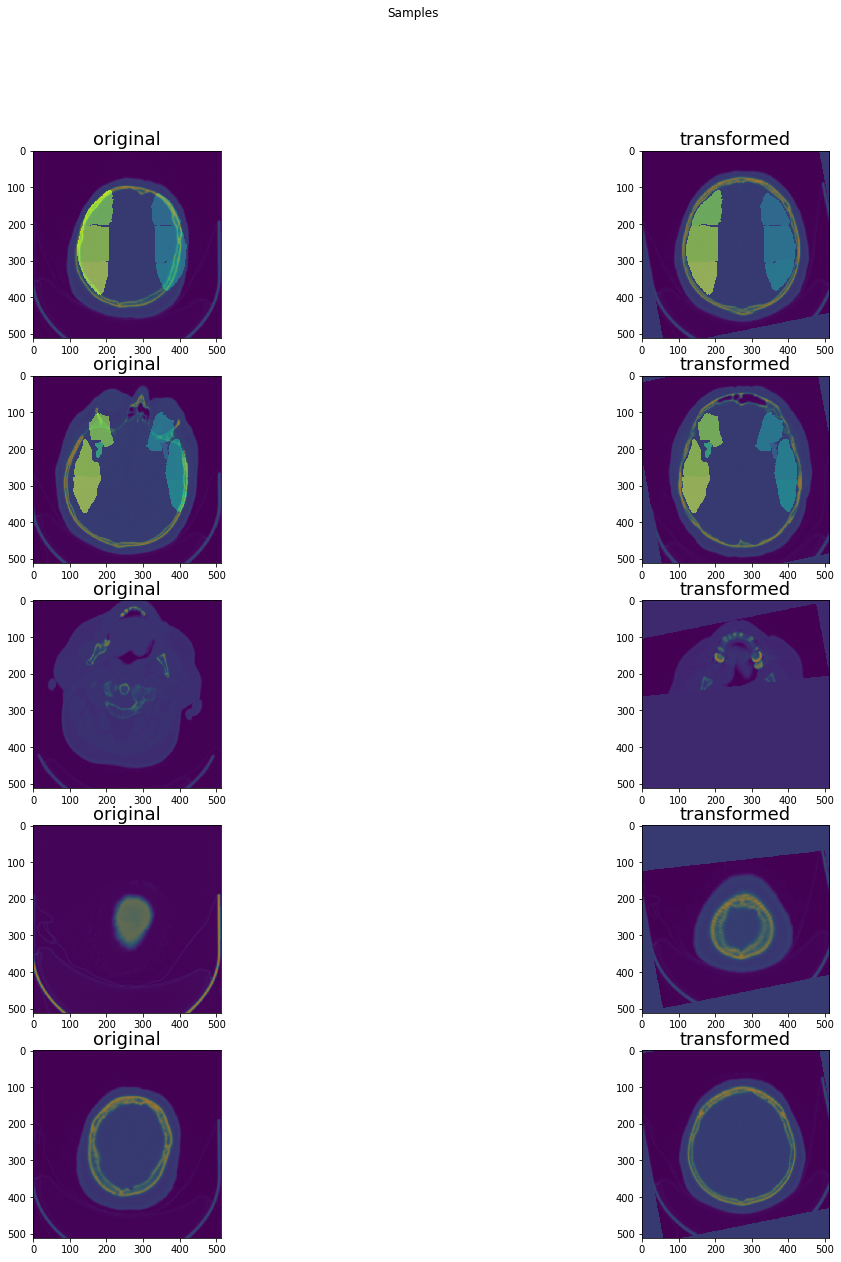

In [17]:
plot_samples(5, CT_array, CT_array_tranformed, left_mask_array)

Looks like masks became more accurate after tranformations. However, some of the images started to look a little worse and less clear. Not sure if its' a bug or just the way it should be. Since I don't have enough time to study the SimpleITK package accurately let's leave it the way it is.

In the end, the biggest work was finding and understanding how to apply transformations from the file. From there begins the usual task of image segmentation. 

## DataLoader

I don't have much experience with CT. As far as I understand it is possible to use whole CT images, generate multiple channel images (e.g. by taking slices for different areas: bone, blood, etc.) or use single channel images. Since we have very little data, I decided to use single-channel images. In total there are about 600 of them.

There are no labels for image 4 (fixed). I don't know if this is a bug or a feature, anyway it is impossible to use this image for train. This leaves us with a total of 6 images. We will use 5 for train and 1 to check results. 

*Update: after fix we have 7 images. Images 1-6 are for training and 7 for validation.

In [18]:
# dataloader for nn
from torch.utils.data.sampler import Sampler
class BrainLoader(Dataset):
    def __init__(self, data_path, transforms = None, img_names = None):
        self.data_path = data_path
        self.img_indexes = img_names
        self.shapes = []
        self.images = []
        self.masks = []
        self.transforms = transforms
        for ct_path in [data_path + f'{x}.nii' for x in img_names]:
            img = sitk.ReadImage(ct_path)
            angle =  sitk.ReadTransform(ct_path.replace('.nii', '.txt'))
            img = sitk.Resample(img, angle)
            CT_array = sitk.GetArrayViewFromImage(img).astype(np.float16)
            self.shapes.append(CT_array.shape[0])
            self.images.append(CT_array)
            
            mask = nib.load(ct_path.replace('.nii', '-seg.nii'))
            mask_array = mask.get_fdata()
            mask_array = mask_array.T
            self.masks.append(mask_array)
        
        s = 0
        self.index_calc = [int(s+np.sum(self.shapes[:x])) for x in range(1,len(self.shapes))]
       
        
    def __getitem__(self, idx):
        i = np.where((np.array(self.index_calc) - idx) >= 0)[0]
        if len(i) >= 1:
            i = i[0]
        else:
            i = len(self.images) - 1
        internal_index = idx - 1 if i == 0 else idx - self.index_calc[i-1] - 1
        img = np.expand_dims(self.images[i][internal_index], axis=-1)
        mask = self.masks[i][internal_index]
        mask = array2mask(mask)
        if self.transforms is not None:
            augument = self.transforms(image=img.astype(np.float32), 
                                       mask=mask.astype(np.float32))
            img = augument['image']
            mask = augument['mask']
        return img, mask
    def __len__(self):
        return np.sum(self.shapes)
    

#### Quick check data generation 

In [19]:
train_dataset = BrainLoader(data_path = 'data/', transforms = train_tranforms, img_names=[1,2,3,4,5,6])

In [20]:
img, mask = train_dataset[2]
img.shape, mask.shape

((512, 512, 1), (512, 512, 20))

In [21]:
trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)

In [22]:
%%time
for i, (x,y) in enumerate(trainloader):
    if i == 5:
        break

CPU times: user 24.9 s, sys: 2.59 s, total: 27.5 s
Wall time: 7.63 s


In [23]:
val_dataset = BrainLoader(data_path = 'data/', transforms=None, img_names=[7])
img, mask = val_dataset[2]
img.shape, mask.shape

((512, 512, 1), (512, 512, 20))

In [24]:
%%time
valloader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=0)
for i, (x,y) in enumerate(valloader):
    if i == 5:
        break

CPU times: user 48.4 s, sys: 5.54 s, total: 54 s
Wall time: 7.28 s


## Model

Since goal of this task is only to demonstrate the general ability of our pipaline I will not spent a lot of time to impove model performance. I will make experiments with a simple model and a rather simple training process. Of course it is possible to improve these approaches using more modern models, as well as improving the training process - using a different optimizer, more careful choice of lr, etc.

In [25]:
model = smp.Unet("resnet50",encoder_weights="imagenet", in_channels = 1,classes = 20,decoder_use_batchnorm = False).cuda()
optim = Adam(model.parameters(),lr=3e-4)

In [26]:
def train_one_epoch(trainloader, model, optim):
    train_loss = 0
    metric = 0
    dices = []
        
    model = model.train();
    for x,y in trainloader:
        x = x.permute((0,3,1,2)).cuda().float()
        y = y.permute((0,3,1,2)).cuda().float()
        y_pred = model(x)
        l = loss(y_pred, y)
        val_masks = torch.sigmoid(y_pred).detach().cpu().numpy()
        true_masks = y.detach().cpu().numpy()
        for pred_mask, true_mask in zip(val_masks, true_masks):
            pred_mask = mask2array(mask_tresholed(np.moveaxis(pred_mask, 0, 2)))
            true_mask = mask2array(np.moveaxis(true_mask, 0, 2))
            dices.append(dice_score(pred_mask, true_mask))
        optim.zero_grad()
        l.backward()
        optim.step()
        train_loss += l.item()
    print('train loss = ', train_loss / len(trainloader), 'train dice = ', np.mean(dices))

In [27]:
def val_one_epoch(valloader, model):
    val_loss = 0
    dices = []
    model = model.eval();
    with torch.no_grad():
        for x,y in valloader:
            x = x.permute((0,3,1,2)).cuda().float()
            y = y.permute((0,3,1,2)).cuda().float()
            y_pred = model(x)
            l = loss(y_pred, y)
            val_masks = torch.sigmoid(y_pred).detach().cpu().numpy()
            true_masks = y.detach().cpu().numpy()
            for pred_mask, true_mask in zip(val_masks, true_masks):
                pred_mask = mask2array(mask_tresholed(np.moveaxis(pred_mask, 0, 2)))
                true_mask = mask2array(np.moveaxis(true_mask, 0, 2))
                dices.append(dice_score(pred_mask, true_mask))
            val_loss += l.item()
        print('val loss = ', val_loss / len(valloader), 'val dice = ', np.mean(dices))
    return np.mean(dices)

In [28]:
def change_lr(optim, reduce_coef = 0.5):
    for g in optim.param_groups:
        g['lr'] = g['lr'] * reduce_coef
    print('lr = ', g['lr'])


In [ ]:
max_val_dice = -1
change_lr_epochs = [5, 10, 17, 23, 29, 35]
for epoch in range(40):
    if epoch in change_lr_epochs:
        change_lr(optim)
    print(f"Epoch # {epoch}")
    train_one_epoch(trainloader, model, optim)
    val_dice = val_one_epoch(valloader, model)
    if (val_dice > max_val_dice):
        max_val_dice = val_dice
        if (epoch > 10):
            torch.save(model.state_dict(),'model_{}'.format(epoch))
        
    torch.cuda.empty_cache()

Epoch # 0
train loss =  0.3601036113454029 train dice =  0.004437715500016004
val loss =  0.031927314187799184 val dice =  0.0
Epoch # 1
train loss =  0.01461095130071044 train dice =  0.0
val loss =  0.013351722620427608 val dice =  0.0
Epoch # 2
train loss =  0.011699079198297112 train dice =  0.0
val loss =  0.012683195128504719 val dice =  0.0
Epoch # 3
train loss =  0.010893934592604636 train dice =  0.0
val loss =  0.012278117405782853 val dice =  0.0
Epoch # 4
train loss =  0.010071893327403814 train dice =  0.0
val loss =  0.013053050464285272 val dice =  0.0
lr =  0.00015
Epoch # 5
train loss =  0.009231342014390975 train dice =  0.0016916551901973215
val loss =  0.0101432523557118 val dice =  0.009476620786059408
Epoch # 6
train loss =  0.008241055725375191 train dice =  0.006311690251701176
val loss =  0.008892878890037537 val dice =  0.00029826863629874045
Epoch # 7
train loss =  0.007361717289313674 train dice =  0.029564027053632015
val loss =  0.00989562492551548 val dic

Part of the training log is sadly lost - my bad, not saved in the file. But no problem we can see the result on the validation later.

## Check predictions

Now let's see how our model behaves on validation. Let's start by choosing the best model and save the predictions and pictures. 

In [29]:
def make_predictions(valloader, model):
    val_loss = 0
    model = model.eval();
    val_masks = []
    true_masks = []
    images = []
    with torch.no_grad():
        for x,y in valloader:
            x = x.permute((0,3,1,2)).cuda().float()
            y = y.permute((0,3,1,2)).cuda().float()
            y_pred = model(x)
            for pred in  torch.sigmoid(y_pred).detach().cpu().numpy():
                val_masks.append(pred)
            for pred in  y.detach().cpu().numpy():
                true_masks.append(pred)
            for img in x.detach().cpu().numpy():
                images.append(img)
            l = loss(y_pred, y)
            val_loss += l.item()
        return val_masks, true_masks, images

In [30]:
epoch = 30
model.load_state_dict(torch.load('model_{}'.format(epoch)))

<All keys matched successfully>

In [31]:
val_masks, true_masks, images = make_predictions(valloader, model)

## Check one image

Let's see predictions for one image for example.

In [32]:
ind = 60
pred_mask = mask2array(mask_tresholed(np.moveaxis(val_masks[ind], 0, 2)))
true_mask = mask2array(np.moveaxis(true_masks[ind], 0, 2))

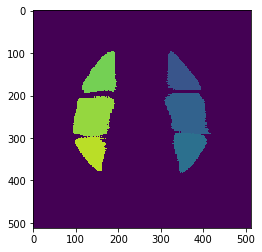

In [33]:
plt.imshow(pred_mask)

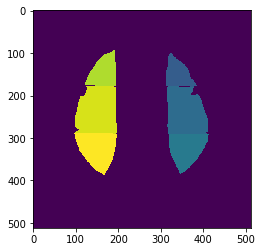

In [34]:
plt.imshow(true_mask)

In [35]:
dice_score(pred_mask, true_mask)

0.8291647261868887

## Check predictions by CT

##### Let's see how model trained on individual image

In [36]:
def calc_dice(val_masks, true_masks):
    dices = []
    for pred_mask, true_mask in zip(val_masks, true_masks):
        pred_mask = mask2array(mask_tresholed(np.moveaxis(pred_mask, 0, 2)))
        true_mask = mask2array(np.moveaxis(true_mask, 0, 2))
        dices.append(dice_score(pred_mask, true_mask))
    return np.mean(dices)

In [37]:
def dice_for_CT(image_name):
    val_dataset = BrainLoader(data_path = 'data/', transforms=None, img_names=[image_name])
    valloader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=0)
    val_masks, true_masks, images = make_predictions(valloader, model)
    return calc_dice(val_masks, true_masks)

In [38]:
for image_name in range(1, 8):
    d = dice_for_CT(image_name)
    print(f'dice for image {image_name} = {d}')

dice for image 1 = 0.2780704007755398
dice for image 2 = 0.32894662821136006
dice for image 3 = 0.27386273354424795
dice for image 4 = 0.27560750172756704
dice for image 5 = 0.2979891303447814
dice for image 6 = 0.3399700215329654
dice for image 7 = 0.2039525223819074


You can see that the behavior on all pictures from the train is about the same (before fixing the error in the task you would see much lower results for pict 2 and 5). And the validation dice is not so far from the training (less then 0.1).

## Overall dice

Let's check validation dice

In [39]:
dices = []
for pred_mask, true_mask in zip(val_masks, true_masks):
    pred_mask = mask2array(mask_tresholed(np.moveaxis(pred_mask, 0, 2)))
    true_mask = mask2array(np.moveaxis(true_mask, 0, 2))
    dices.append(dice_score(pred_mask, true_mask))

In [40]:
np.mean(dices)
dices[::8]

0.2039525223819074

[0.6035577123941444,
 0.0,
 0.0,
 0.609291101055807,
 0.0,
 0.0,
 0.0,
 0.0,
 0.8102099956333612,
 0.0,
 0.0,
 0.0,
 0.0]

You can see that the dice score is quite low. But at the same time for many pictures it is 0. Usually this means that for an empty mask our model predicts something, or vice versa. Let's remove "noisy" predictions, i.e. predictions that are too small, which are most likely obtained by error. 

This most likely means that the model is undertrained and we can improve the quality by training a few more epochs. 

## Remove noisy preds

In [41]:
dices = []
for pred_mask, true_mask in zip(val_masks, true_masks):
    non_zero = np.where(mask2array(mask_tresholed(np.moveaxis(pred_mask, 0, 2))) != 0)[0]
    if len(non_zero) < 30:
        pred_mask = np.zeros((512,512))
    else:
        pred_mask = mask2array(mask_tresholed(np.moveaxis(pred_mask, 0, 2)))
    true_mask = mask2array(np.moveaxis(true_mask, 0, 2))
    dices.append(dice_score(pred_mask, true_mask))

In [42]:
np.mean(dices)
dices[::8]

0.8215995812054367

[0.6035577123941444,
 1.0,
 1.0,
 0.609291101055807,
 1.0,
 1.0,
 1.0,
 0.0,
 0.8102099956333612,
 0.0,
 1.0,
 1.0,
 1.0]

Great, now we're pretty good at predicting empty masks and our dice have grown by several times. Not as high as we would have liked, though. 

Let's also check "cleaned dice" for train images.

In [43]:
def calc_dice_clean(val_masks, true_masks):
    dices = []
    for pred_mask, true_mask in zip(val_masks, true_masks):
        non_zero = np.where(mask2array(mask_tresholed(np.moveaxis(pred_mask, 0, 2))) != 0)[0]
        if len(non_zero) < 30:
            pred_mask = np.zeros((512,512))
        else:
            pred_mask = mask2array(mask_tresholed(np.moveaxis(pred_mask, 0, 2)))
        true_mask = mask2array(np.moveaxis(true_mask, 0, 2))
        dices.append(dice_score(pred_mask, true_mask))
    return np.mean(dices)

In [44]:
def dice_for_CT_clean(image_name):
    val_dataset = BrainLoader(data_path = 'data/', transforms=None, img_names=[image_name])
    valloader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=0)
    val_masks, true_masks, images = make_predictions(valloader, model)
    return calc_dice_clean(val_masks, true_masks)

In [46]:
for image_name in range(1, 7):
    d = dice_for_CT_clean(image_name)
    print(f'dice for image {image_name} = {d}')

dice for image 1 = 0.9160014352582985
dice for image 2 = 0.9207833629052375
dice for image 3 = 0.9469394953242639
dice for image 4 = 0.9455103631610273
dice for image 5 = 0.9326046932124517
dice for image 6 = 0.9343095174838294


Well seems like training dice is close to perfect. 

## Plot some predictions

Finally, let's draw some predictions and see how our model does in general

In [47]:
# plot orginal brain images and images after affine tranformation
def plot_predictions(n, images, true_masks, predicted_masks):
    fig=plt.figure(figsize=(20, 20))
    fig.suptitle('Samples')
    columns = 2
    rows = n
    
    #mapping[str(predicted_label)], mapping[str(true_label)]
    for i in range(0, rows*columns, 2):
        # try:
        ind = np.random.randint(len(images))
        img = images[ind][0]
        
        true_mask = mask2array(np.moveaxis(true_masks[ind], 0, 2))
        
        predicted_mask = predicted_masks[ind]
        predicted_mask = mask2array(mask_tresholed(np.moveaxis(predicted_mask, 0, 2)))
        non_zero = np.where(predicted_mask != 0)[0]
        if len(non_zero) < 30:
            predicted_mask = np.zeros((512,512))
            
        ax = fig.add_subplot(rows, columns, i+1)
        plt.imshow(img)
        plt.imshow(true_mask, alpha=0.5)
        plt.title(f"true mask", fontsize=18)
        ax = fig.add_subplot(rows, columns, i+2)
        plt.imshow(img)
        plt.imshow(predicted_mask, alpha=0.5)
        plt.title(f"prediction", fontsize=18)

            
        # except:
            # pass
    plt.show()

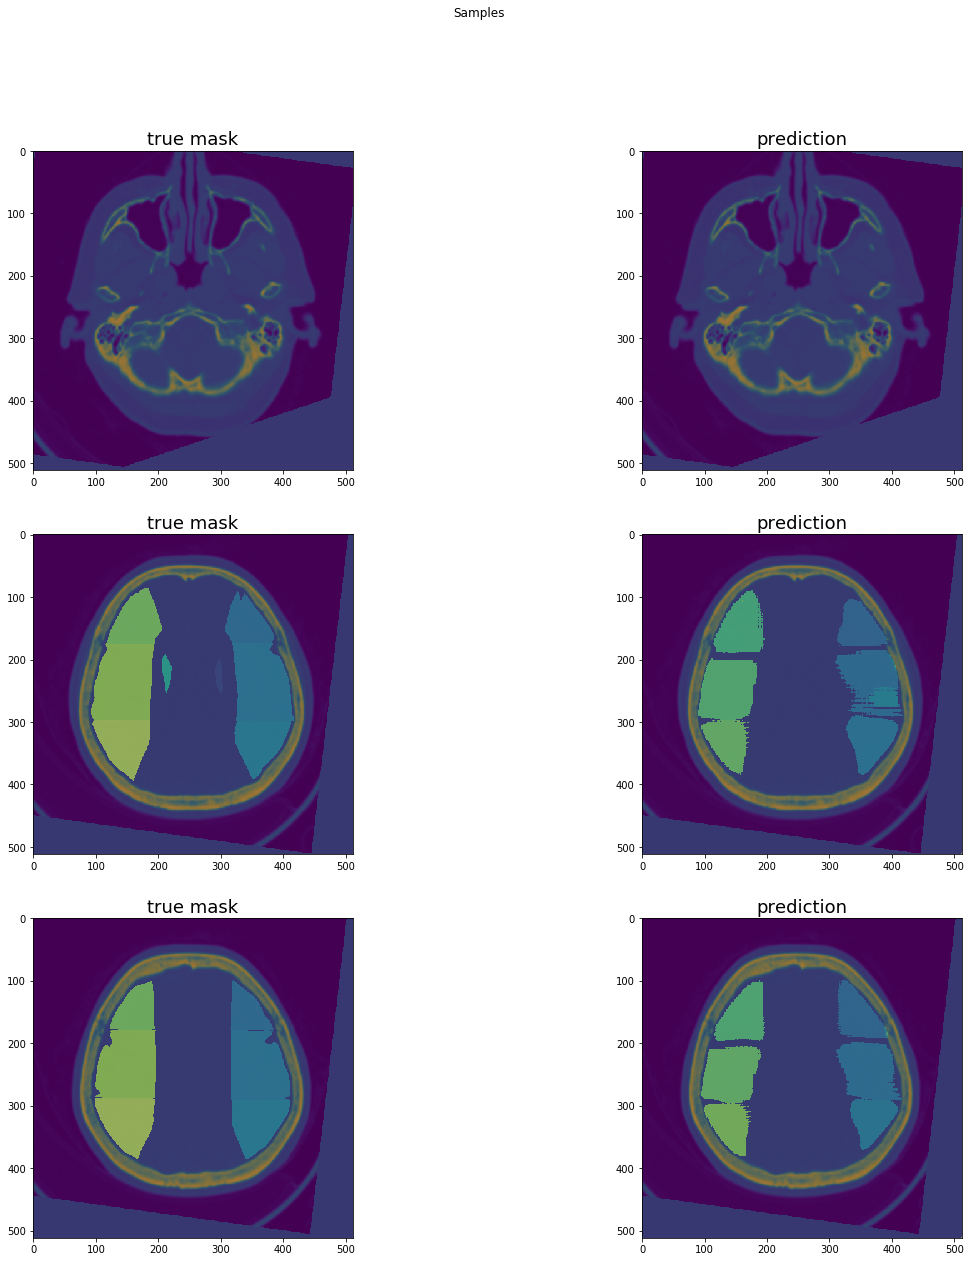

In [49]:
plot_predictions(3, images, true_masks, val_masks)

Yes indeed our predictions are not perfect yet but the direction seems to be right. In addition, we are quite good at predicting empty masks. 

## Conclusion & some thoughts

First, I would like to thank the reviewer for his time. Any feedback would be valuable, so I would be happy to hear from you. 

There is still a lot of room for improvement in our model. The simplest model Unet with resnet50 backbone was used. I trained only 30 epochs and used a simple handmade sheduler, while the Cosine sheduler could have been much better. I haven't done enough research on what augmentations can help reduce overfitting (especially given the small amount of data). Focal loss might behave better. But since that's just test assignment, I consider result suitable and will be happy to demonstrate all the improvements during my first work project. :-)  